# Introduction

I am going to perform time series forecasting with XGBOOST.

### Data

Data contains over 7 years(2011-12-31 01:00:00 - 2018-01-02 00:00:00) of hourly energy consumption data from ComEd in Megawatts. 

### Goal

1. build a model to predict energy consumption?

2. finding trends in energy consumption around hours of the day, holidays, or long term trends?

3. understanding how daily trends change depending of the time of year?

### 1. Loading libraries

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp
import pandas.util.testing as tm
import IPython
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 2. Reading Data

In [4]:
df_comEd = pd.read_csv('Data/COMED_hourly.csv', index_col=[0], parse_dates=[0])

In [7]:
# examining the data using pandas_profiling
df_comEd.head()
pp.ProfileReport(df_comEd)

,COMED_MW
Datetime,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


ProfileReport examine the data and provides info, variables, correlations, missing values, statistical analysis and provides head and tail values of the data. 

There are total of <b>66497 rows</b> with <b>no missing values</b>, <b>no duplicate rows</b>.

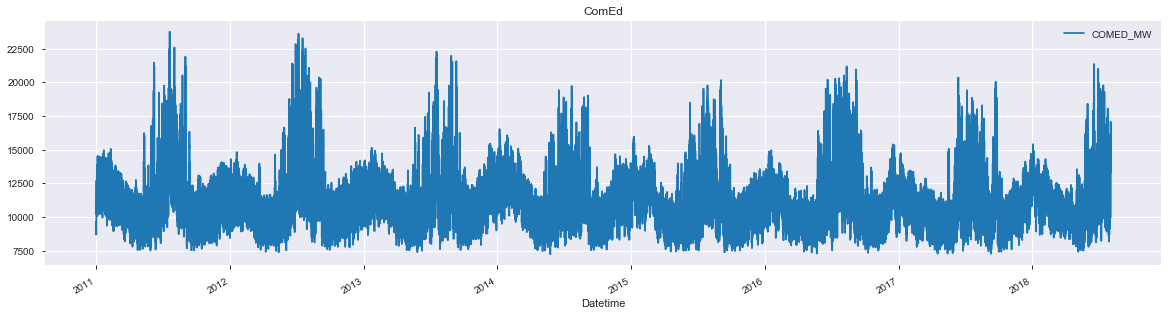

In [8]:
# visualisation using plot
plot_df_comEd = df_comEd.plot(style='', figsize=(20,5), title='ComEd')

In [9]:
# creating time series features from date_time to see trends hourly/monthly
def create_features(df_comEd):
    df = df_comEd.copy()
    
    df['Date'] = df.index
    
    df['Hour'] = df['Date'].dt.hour
    
    df['Day_Of_A_Week'] = df['Date'].dt.dayofweek
    df['Day_Of_A_Month'] = df['Date'].dt.day
    df['Day_Of_An_Year'] = df['Date'].dt.dayofyear
    
    df['Month'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter
    df['Year'] = df['Date'].dt.year
    
    df['Week_Of_An_Year'] = df['Date'].dt.weekofyear
    
    X = df[['Hour','Day_Of_A_Week','Day_Of_A_Month','Day_Of_An_Year','Month',
           'Quarter','Year','Week_Of_An_Year']]
    y = df['COMED_MW']
    df_comEd_features_target = pd.concat([X, y], axis=1)
    
    return df_comEd_features_target

df_comEd_features_target = create_features(df_comEd)

df_comEd_features_target.head()
pp.ProfileReport(df_comEd_features_target)

,Hour,Day_Of_A_Week,Day_Of_A_Month,Day_Of_An_Year,Month,Quarter,Year,Week_Of_An_Year,COMED_MW
Datetime,,,,,,,,,
2011-12-31 01:00:00,1,5,31,365,12,4,2011,52,9970.0
2011-12-31 02:00:00,2,5,31,365,12,4,2011,52,9428.0
2011-12-31 03:00:00,3,5,31,365,12,4,2011,52,9059.0
2011-12-31 04:00:00,4,5,31,365,12,4,2011,52,8817.0
2011-12-31 05:00:00,5,5,31,365,12,4,2011,52,8743.0


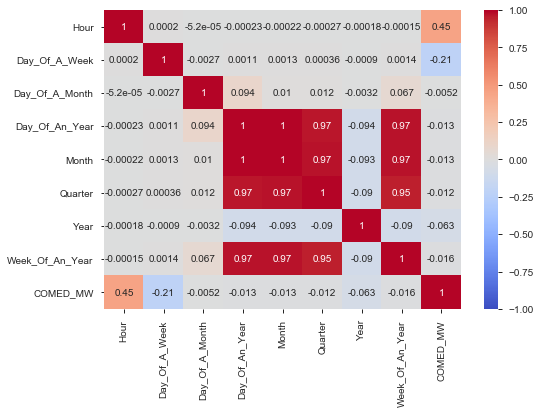

In [12]:
# Seaborn correlation heatmap to gain insight into the data
# It shows pearson correlation coefficient for each feature to every other.

sns.heatmap(df_comEd_features_target.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

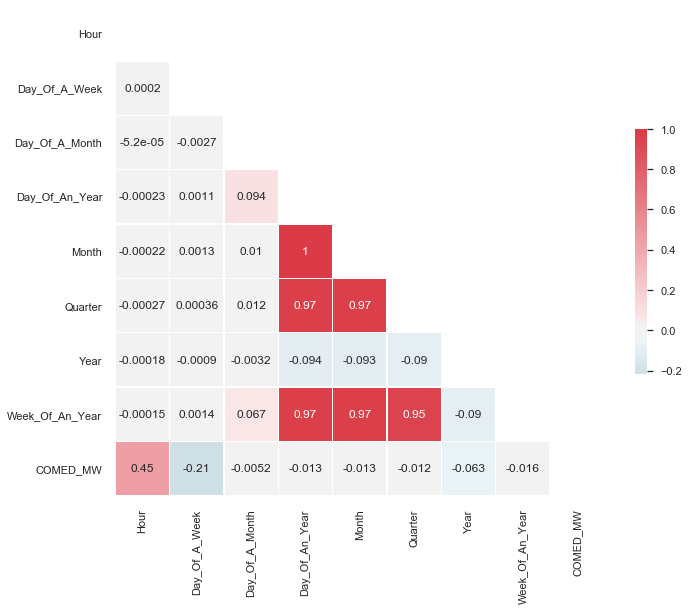

In [18]:
# plotting a diagonal crrelation matrix

sns.set(style="white")

# Compute the correlation matrix
corr = df_comEd_features_target.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

A postive medium correation between COMED_MW and Hour and 
A negative small correlation between COMED_MW and other features

Text(0.5, 0.98, 'Power Usage in MW by Hour')

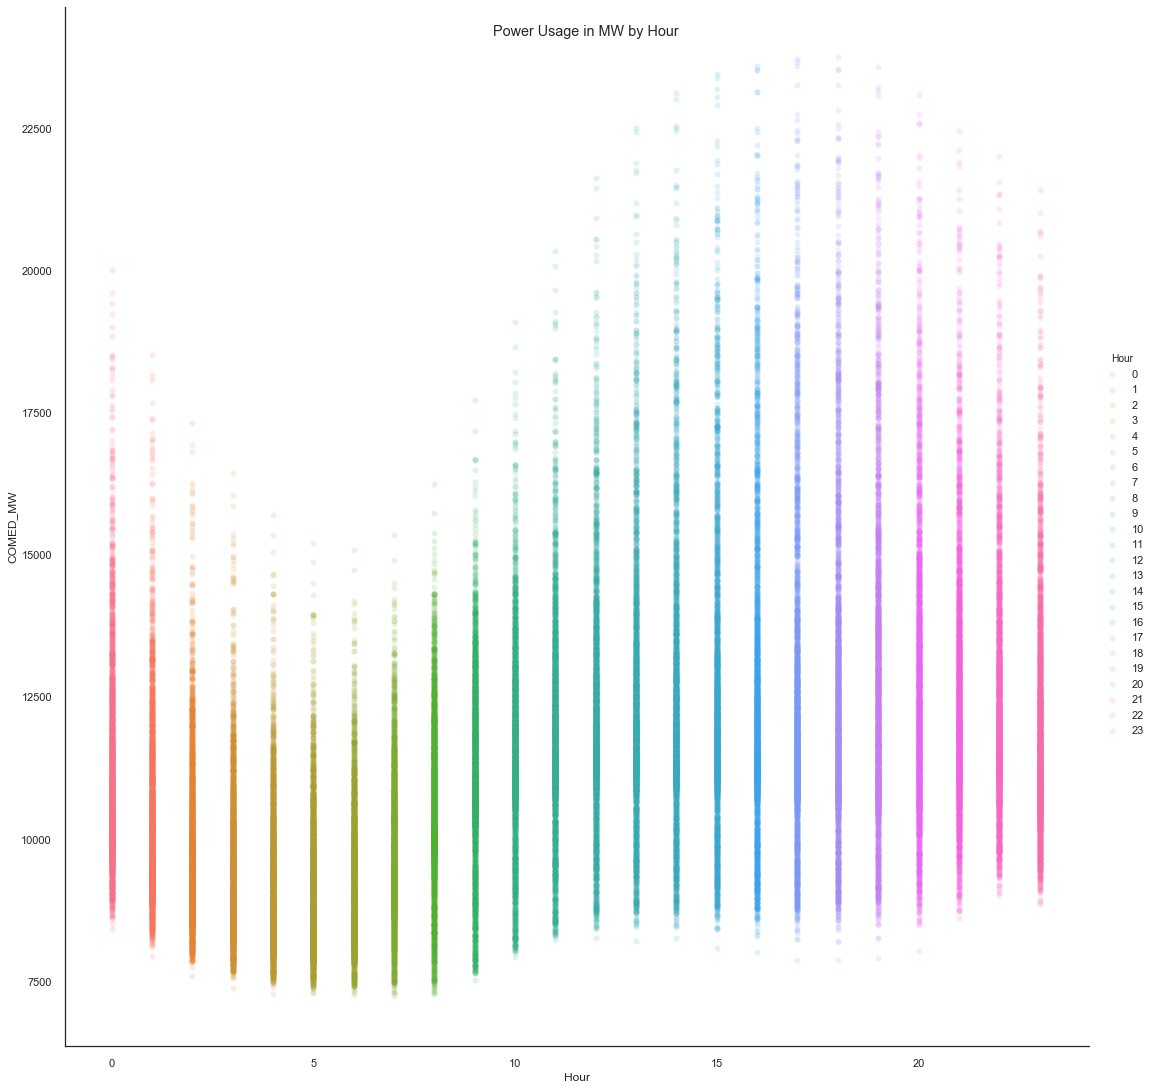

In [22]:
# plot the features to see the trend
import matplotlib.pyplot as plt 
sns.pairplot(df_comEd_features_target.dropna(),
             hue='Hour',
             x_vars=['Hour'],
             y_vars='COMED_MW',
             height=15,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Usage in MW by Hour')
plt.show()

Text(0.5, 0.98, 'Power Usage in MW')

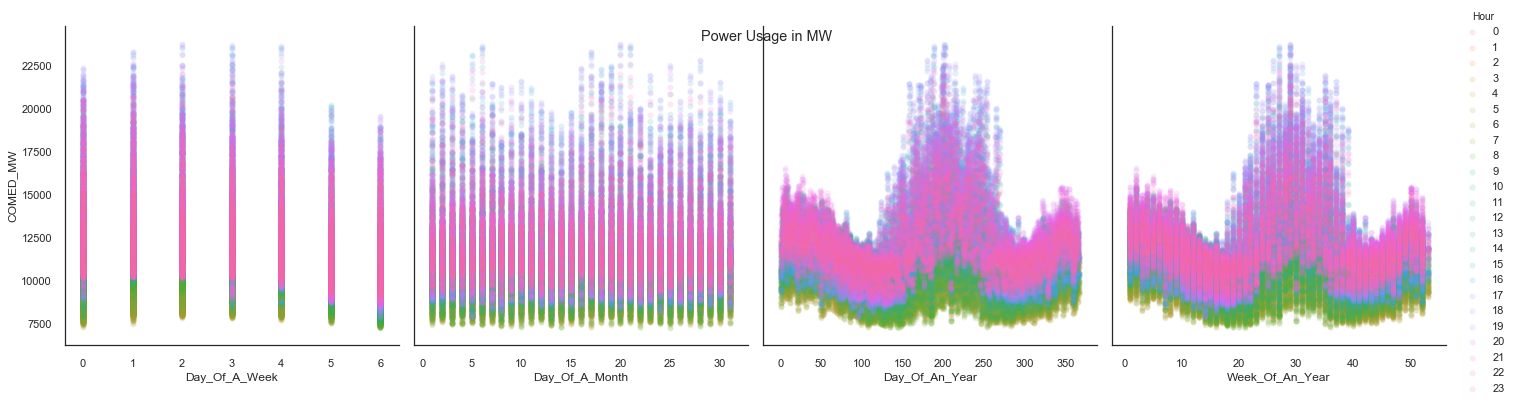

In [23]:
# plot the features to see the trend
import matplotlib.pyplot as plt 
sns.pairplot(df_comEd_features_target.dropna(),
             hue='Hour',
             x_vars=['Day_Of_A_Week','Day_Of_A_Month',
                     'Day_Of_An_Year','Week_Of_An_Year'],
             y_vars='COMED_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Usage in MW')
plt.show()

In [ ]:
# plot the features to see the trend
import matplotlib.pyplot as plt 
sns.pairplot(df_comEd_features_target.dropna(),
             hue='Hour',
             x_vars=['Month','Quarter',
                     'Year'],
             y_vars='COMED_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Usage in MW')
plt.show()

Text(0.5, 0.98, 'Power Usage in MW')